In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm 


In [2]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2024-11-01 22:22:37--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-11-01 22:22:37--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  2.71MB/s    in 1m 50s  

2024-11-01 22:24:27 (2.16 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [5]:
# !unzip tiny-imagenet-200.zip

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pywt
import torchvision.datasets as datasets


# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for Tiny ImageNet
])



# Download and load the training data
trainset = datasets.ImageFolder(root='tiny-imagenet-200/train',transform=transform)
testset = datasets.ImageFolder(root='tiny-imagenet-200/val', transform=transform)

print(len(trainset))

/work/pi_mccallum_umass_edu/aamballa_umass_edu/amballaavinash/.conda/envs/Diffusion/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


85948


In [3]:
trainset[0][0].min(), trainset[0][0].max(), trainset[0][0].shape

(tensor(0.0078), tensor(1.), torch.Size([3, 64, 64]))

In [4]:
# Upscale the high-frequency components (LH, HL, HH)
def upscale_components(LH, HL, HH, scale=2):
    # Use OpenCV to resize the detail coefficients (high-frequency components)
    # replace with original
    LH_upscaled = torch.nn.functional.interpolate(torch.from_numpy(LH).unsqueeze(0).unsqueeze(0), size = (LH.shape[1] * scale, LH.shape[0] * scale)).numpy()[0][0]   # cv2.resize(LH, (LH.shape[1] * scale, LH.shape[0] * scale), interpolation=cv2.INTER_LINEAR)
    HL_upscaled = torch.nn.functional.interpolate(torch.from_numpy(HL).unsqueeze(0).unsqueeze(0), size = (HL.shape[1] * scale, HL.shape[0] * scale)).numpy()[0][0] #cv2.resize(HL, (HL.shape[1] * scale, HL.shape[0] * scale), interpolation=cv2.INTER_LINEAR)
    HH_upscaled = torch.nn.functional.interpolate(torch.from_numpy(HH).unsqueeze(0).unsqueeze(0), size = (HH.shape[1] * scale, HH.shape[0] * scale)).numpy()[0][0]   #cv2.resize(HH, (HH.shape[1] * scale, HH.shape[0] * scale), interpolation=cv2.INTER_LINEAR)
    return LH_upscaled, HL_upscaled, HH_upscaled


# CIFAR-10 image is 3-channel (RGB), apply wavelet transform to each channel separately
def apply_wavelet(img_channel, wavelet='haar'):
    # Apply 2D Discrete Wavelet Transform (DWT) to each channel
    coeffs2 = pywt.dwt2(img_channel, wavelet)
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH, coeffs2

# Apply inverse wavelet transform
def inverse_wavelet(coeffs2, wavelet='haar'):
    return pywt.idwt2(coeffs2, wavelet)



# Apply wavelet transform to all three channels of the CIFAR image
channels = ['Red', 'Green', 'Blue']
wavelet = 'haar'  # Haar basis for wavelet decomposition


def wavelet_image(image, upscale = True):
    coeffs = []
    # upscaled_coeffs = {}
    
    for i, channel in enumerate(channels):
        LL, LH, HL, HH, coeffs2 = apply_wavelet(image[:,:,i], wavelet)
        # coeffs[channel] = (LL, LH, HL, HH, coeffs2)

        if upscale:
        # Upscale high-frequency components
            LH, HL, HH = upscale_components(LH, HL, HH, scale=2)
        
        # # Store upscaled coefficients
        # upscaled_coeffs[channel] = (downsampled_image[i,:,:], (LH_upscaled, HL_upscaled, HH_upscaled))
    
        coeffs.extend([LH,HL,HH])

    return torch.tensor(coeffs)


In [5]:
def process_data(dataset, size = 16):

    processed_data = []
    for img in tqdm(dataset):
        img = img[0].permute(1, 2, 0).numpy()

        # input
        resized_img = cv2.resize(img, (size,size), interpolation=cv2.INTER_LINEAR)
        resized_wavelet = wavelet_image(resized_img, upscale = True)

        # target
        ground_truth = wavelet_image(img, upscale = False)
        processed_data.append((resized_wavelet, ground_truth))
                                    
    return processed_data

In [6]:
processed_trainset = process_data(trainset, size=32)
processed_testset = process_data(testset, size=32)

  0%|                                                                                                                                                                                 | 0/85948 [00:00<?, ?it/s]/tmp/ipykernel_747520/1465235469.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(coeffs)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:40<00:00, 99.26it/s]


In [7]:
processed_trainset[0][0].shape, processed_trainset[0][1].shape

(torch.Size([9, 32, 32]), torch.Size([9, 32, 32]))

In [8]:
def show_data(trainloader):
    # Check the shape of the dataset
    dataiter = next(iter(trainloader))
    images, labels = dataiter
    print(f'Batch shape: {images.shape}, Labels shape: {labels.shape}')
    
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    
    # Make a grid from batch
    imshow(torchvision.utils.make_grid(images))
    
    # Display the plot
    plt.show()


Batch shape: torch.Size([100, 3, 64, 64]), Labels shape: torch.Size([100])


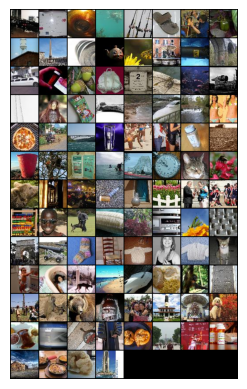

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

show_data(trainloader)

In [10]:
processed_trainloader = torch.utils.data.DataLoader(processed_trainset, batch_size=100, shuffle=True, num_workers=2)
processed_testloader = torch.utils.data.DataLoader(processed_testset, batch_size=100, shuffle=False, num_workers=2)


In [14]:
# Auto encoder (try using from latent diffusion model paper)

In [15]:
import torch.nn as nn
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

In [16]:
net = BasicUNet(in_channels=9, out_channels=9).cuda()
x = torch.rand(8, 9, 32, 32).cuda()
net(x).shape

torch.Size([8, 9, 32, 32])

In [17]:
sum([p.numel() for p in net.parameters()])

321865

Epoch 1/50, Train Loss: 0.00190, Val Loss: 0.00068
Epoch 2/50, Train Loss: 0.00060, Val Loss: 0.00049
Epoch 3/50, Train Loss: 0.00047, Val Loss: 0.00042
Epoch 4/50, Train Loss: 0.00042, Val Loss: 0.00039
Epoch 5/50, Train Loss: 0.00040, Val Loss: 0.00037
Epoch 6/50, Train Loss: 0.00038, Val Loss: 0.00035
Epoch 7/50, Train Loss: 0.00036, Val Loss: 0.00034
Epoch 8/50, Train Loss: 0.00035, Val Loss: 0.00033
Epoch 9/50, Train Loss: 0.00034, Val Loss: 0.00032
Epoch 10/50, Train Loss: 0.00033, Val Loss: 0.00031
Epoch 11/50, Train Loss: 0.00033, Val Loss: 0.00031
Epoch 12/50, Train Loss: 0.00032, Val Loss: 0.00031
Epoch 13/50, Train Loss: 0.00032, Val Loss: 0.00030
Epoch 14/50, Train Loss: 0.00032, Val Loss: 0.00030
Epoch 15/50, Train Loss: 0.00032, Val Loss: 0.00030
Epoch 16/50, Train Loss: 0.00031, Val Loss: 0.00030
Epoch 17/50, Train Loss: 0.00031, Val Loss: 0.00029
Epoch 18/50, Train Loss: 0.00031, Val Loss: 0.00029
Epoch 19/50, Train Loss: 0.00031, Val Loss: 0.00029
Epoch 20/50, Train Lo

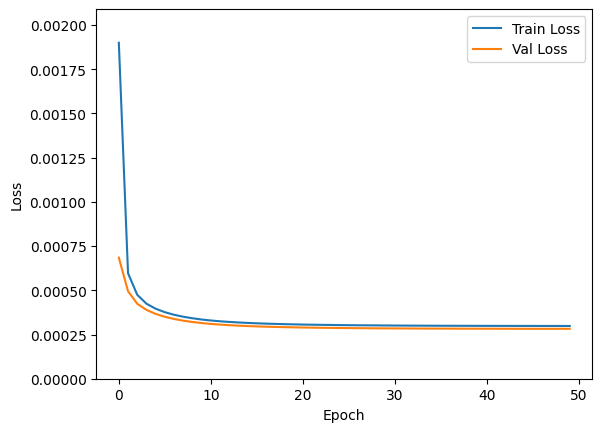

In [19]:
device = "cuda"
n_epochs = 50

# Create the network
net = BasicUNet(in_channels=9, out_channels=9)
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()  # try with L1 loss 

# The optimizer
from torch.optim.lr_scheduler import ExponentialLR

opt = torch.optim.Adam(net.parameters(), lr=1e-4) 

scheduler = ExponentialLR(opt, gamma=0.9)  # Reduce LR by 10% every epoch


# Keeping a record of the losses for later viewing
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0  # For tracking the loss within the epoch
    
    for x, y in processed_trainloader:
        # Move data to GPU
        x = x.to(device)

        # Zero the parameter gradients
        opt.zero_grad()

        # Forward pass
        pred = net(x)

        # Compute loss
        loss = loss_fn(pred, x)  # We are comparing the output to the input (autoencoder style)

        # Backward pass and optimize
        loss.backward()
        opt.step()

        # Track loss
        running_loss += loss.item()

    # Calculate average loss for this epoch
    avg_train_loss = running_loss / len(processed_trainloader)
    train_losses.append(avg_train_loss)

    # Validation step
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for x_val, y_val in processed_testloader:
            x_val = x_val.to(device)

            # Forward pass
            pred_val = net(x_val)

            # Compute validation loss
            val_loss += loss_fn(pred_val, x_val).item()

    avg_val_loss = val_loss / len(processed_testloader)
    val_losses.append(avg_val_loss)

    scheduler.step()

    # Print average losses for this epoch
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}')


# Plot the training and validation loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
plt.show()

In [20]:
torch.save(net, "AE_tiny_imagenet.pth")

In [21]:
# block diagram

![title](blockdiagram.JPG)

In [21]:
def wavelet_inference(input_image, groundtruth_image):
    coeffs = []
    coeffs_gt = []
    
    for i, channel in enumerate(channels):
        LL, LH, HL, HH, coeffs2 = apply_wavelet(input_image[:,:, i], wavelet)
            
        # Upscale high-frequency components
        LH, HL, HH = upscale_components(LH, HL, HH, scale=2)

        coeffs.extend([LH,HL,HH])


        LL_gt, LH_gt, HL_gt, HH_gt, coeffs2_gt = apply_wavelet(groundtruth_image[:,:, i], wavelet)
            
        coeffs_gt.extend([LH_gt,HL_gt,HH_gt])

    coeffs = torch.tensor(coeffs).unsqueeze(0).to(device)

    coeffs_gt = torch.tensor(coeffs_gt).unsqueeze(0).to("cpu")
    
    # infer to auto encoder
    with torch.no_grad():  # No need to track gradients during validation
            denoised_coeffs = net(coeffs)[0].to("cpu")

    print(torch.max(torch.flatten(coeffs_gt)))
    plt.hist(torch.flatten(torch.abs(denoised_coeffs-coeffs_gt)).numpy())
    plt.show()
    upscaled_coeffs = {}
    # Store upscaled coefficients
    for i, channel in enumerate(channels):
        upscaled_coeffs[channel] = (input_image[:,:, i], (denoised_coeffs[3*i], denoised_coeffs[3*i+1], denoised_coeffs[3*i+2]))
    
    
    # Perform inverse wavelet transform with the upscaled high-frequency components
    reconstructed_image = np.zeros((2*input_image.shape[0], 2*input_image.shape[1], 3))
    for i, channel in enumerate(channels):
        reconstructed_image[:, :, i] = inverse_wavelet(upscaled_coeffs[channel], wavelet)
    
    # Display the original and reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(input_image) 
    ax[0].set_title(f"Input Image {input_image.shape}")
    ax[0].axis('off')
    
    ax[1].imshow((reconstructed_image-reconstructed_image.min())/(reconstructed_image.max()-reconstructed_image.min()))  # Reconstructed image
    ax[1].set_title(f"Reconstructed Image {reconstructed_image.shape}")
    ax[1].axis('off')

    ax[2].imshow((groundtruth_image-groundtruth_image.min())/(groundtruth_image.max()-groundtruth_image.min())) 
    ax[2].set_title(f"label Image {groundtruth_image.shape}")
    ax[2].axis('off')

    print("L2 norm between Reconstructed Image and groundtruth image {}".format(np.linalg.norm(groundtruth_image-reconstructed_image)))
    plt.show()

    return reconstructed_image


tensor(0.5549)


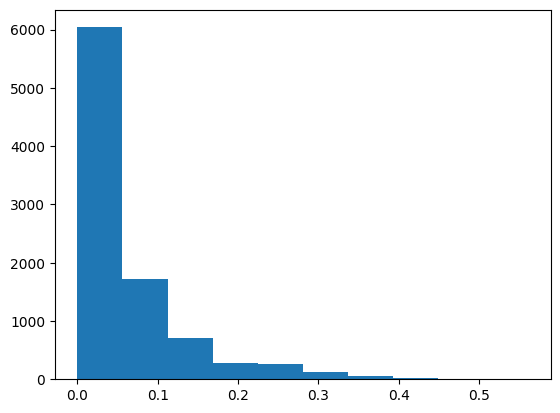

L2 norm between Reconstructed Image and groundtruth image 26.00030416707319


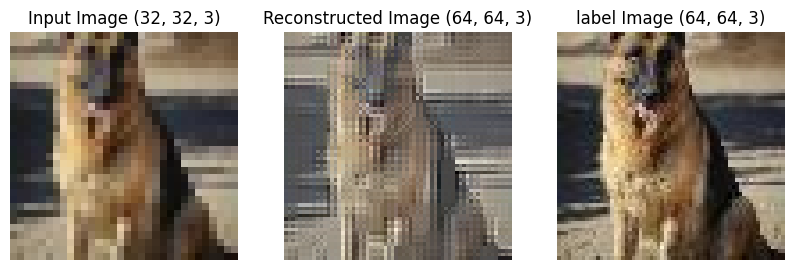

In [23]:
r = np.random.randint(1000)
img = trainset[r][0].permute(1, 2, 0).numpy()

# input
input_image = cv2.resize(img, (32,32), interpolation=cv2.INTER_LINEAR)

reconstructed_image = wavelet_inference(input_image, img)